In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_04 import *

## Initial setup

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [ ]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6745034375, tensor(0.8009)]
valid: [0.32250380859375, tensor(0.9070)]
train: [0.30254333984375, tensor(0.9126)]
valid: [0.2379218994140625, tensor(0.9347)]
train: [0.24497798828125, tensor(0.9289)]
valid: [0.2221502197265625, tensor(0.9363)]


In [ ]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.743376328125, tensor(0.8121)]
valid: [0.3437718994140625, tensor(0.9047)]
train: [0.3448944140625, tensor(0.9008)]
valid: [0.285852490234375, tensor(0.9186)]
train: [0.29494171875, tensor(0.9153)]
valid: [0.2629585693359375, tensor(0.9237)]


In [ ]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

In [ ]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses,self.stats = [],[],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss)        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [ ]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [ ]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [ ]:
@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [ ]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [ ]:
f = sched_lin(1,2)
f(0.3)

1.3

In [ ]:
@annealer
def sched_cos(start, end, pos): return start + math.cos(math.pi*(1-pos)/2.)*(end-start)
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [ ]:
#export
torch.Tensor.ndim = property(lambda x: len(x.shape))

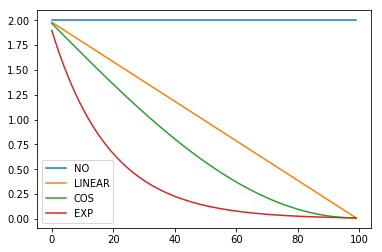

In [ ]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [ ]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [ ]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [ ]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
run.fit(3, learn)

train: [0.775796171875, tensor(0.7836)]
valid: [0.3138823486328125, tensor(0.9129)]
train: [0.2885366796875, tensor(0.9159)]
valid: [0.23632177734375, tensor(0.9304)]
train: [0.24123328125, tensor(0.9309)]
valid: [0.2146678466796875, tensor(0.9381)]


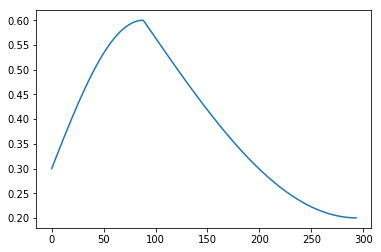

In [ ]:
run.recorder.plot_lr()

## Export

In [ ]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to nb_05.py
